# Model Training Notebook: Tree Pose Classification

## Introduction

This Jupyter Notebook focuses on training a machine learning model to classify the "Tree Pose" as either correct or incorrect based on body landmarks data obtained using BlazePose. The Tree Pose is a common yoga posture that requires a good sense of balance and body positioning. We aim to use the body landmarks data to detect and classify whether an individual is performing the Tree Pose correctly or incorrectly.

### Background

- The Tree Pose is a popular yoga posture that involves standing on one leg with the other leg resting on the inner thigh or calf of the supporting leg.
- Correct execution of the Tree Pose relies on precise body positioning, including the alignment of various body landmarks.
- BlazePose is a pose estimation model that provides the locations of key body landmarks.

### Objectives

The primary objectives of this project are as follows:

1. Collect and preprocess body landmarks data using BlazePose for individuals performing the Tree Pose.
2. Develop a machine learning model to classify whether a Tree Pose is performed correctly or incorrectly.
3. Evaluate the model's performance on validation and test datasets.
4. Create visualizations and analyze the model's results.

### Dataset

We have collected a dataset of body landmarks obtained through BlazePose, where each data point includes the positions of key body landmarks during the Tree Pose. This dataset is used for training, validation, and testing.

### Machine Learning Model

The machine learning model used for classification is a neural network with a specific architecture. We will discuss the model's architecture, training process, and evaluation metrics in this notebook.

### Note

Please make sure you have the necessary dependencies, dataset, and BlazePose implementation ready before running this notebook.


In [4]:
# Import Libraries

# Data Manipulation and Preprocessing
import numpy as np
import pandas as pd
import csv

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Visualization
from matplotlib import pyplot as plt

# Miscellaneous
import os
import sys

# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

import utils
from data import BodyPart

zsh:1: no matches found: https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite


fatal: destination path 'examples' already exists and is not an empty directory.


# Data Loading and Preprocessing for Pose Classification

## Data Source and Preprocessing

The CSV files used in this code were created by processing pose images with BlazePose to obtain pose landmarks. The source images are from the `/datasets/tree_images` directory.

- **Training and Testing Split:** The dataset has been divided into training and testing sets with an 80-20 split ratio.

### CSV Files and Processing Details

- **Training Data:** The CSV file located at `csvs_out_train_path` contains pose landmarks and labels for the training dataset.

- **Testing Data:** The CSV file located at `csvs_out_test_path` contains pose landmarks and labels for testing the model. Additionally, data from the `csvs_out_test_real` CSV file is available for further testing.

- **Real Test Data:** The `csvs_out_test_real` CSV file contains pose landmarks obtained from images of real individuals. These images were collected by the author of this project, ensuring that the test dataset includes real-world, diverse scenarios.

**Note:** The original images used to create the real test dataset are not included in the dataset directory due to privacy considerations.


This code loads and preprocesses the data for the subsequent training and evaluation of a pose classification model. The pose landmarks are used as input features, and class labels are used for training and testing.


In [5]:
csvs_out_train_path = '../Dataset/tree_csv/train.csv'
csvs_out_test_path = '../Dataset/tree_csv/test.csv'
csvs_out_test_real = '../Dataset/tree_csv/test_real.csv'

def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['filename'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')

  return X, y, classes, dataframe

# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

X_train = X
y_train = y

# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

X_test_real, y_test_real, _3, df_test3 = load_pose_landmarks(csvs_out_test_real)


# Pose Landmarks Normalization

## Landmarks Normalization Process

In this section, the code focuses on normalizing the pose landmarks obtained from the images. The normalization process includes the following steps:

1. **Centering the Pose:** The pose landmarks are adjusted to ensure that the center of the pose becomes (0, 0) in the coordinate system. This step helps eliminate any translation-related variations in the pose data.

2. **Scaling to a Constant Pose Size:** The landmarks are scaled to a consistent pose size, ensuring that the pose landmarks are comparable across different samples. This step helps in achieving consistent features for the pose classification model.

3. **Embedding Transformation:** The normalized landmark coordinates are converted into a pose embedding, which is a flattened vector. This embedding serves as the input features for the pose classification model.

By applying these normalization techniques, the code prepares the pose landmarks for effective use in training and evaluating the pose classification model.

**Reference:** The normalization code is adapted from the TensorFlow Lite [Pose Classification Tutorial](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb).

In [6]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center
  
def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (13*2), 13, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (13*2), 13, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((13, 3))(landmarks_and_scores)
  #print(reshaped_inputs[:, :, 2])
  #print(reshaped_inputs[:, :, :2]);

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

X_normalized = landmarks_to_embedding(X_train);

# Model Definition and Training

In this section, we define and train the pose classification model.

## Model Architecture

- Input Layer: The model takes input features representing normalized pose landmarks.
- Embedding Layer: Converts pose landmarks for classification.
- Dense Layers: Two hidden layers with ReLU6 activation.
- Output Layer: A single neuron for binary classification.

In [7]:
from keras import Sequential;
from keras.layers import Dense;

# Define the model
inputs = tf.keras.Input(shape=(39))
embedding = landmarks_to_embedding(inputs)

layer = Dense(90, activation=tf.nn.relu6)(embedding)
layer = Dense(40, activation=tf.nn.relu6)(layer)
outputs = Dense(1, activation="sigmoid")(layer)

model = keras.Model(inputs, outputs)

## Model Compilation

- Loss Function: Binary Cross-Entropy.
- Optimizer: Adam.

In [8]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer= tf.keras.optimizers.Adam(),
)

## Model Training

- Trained on X_train and y_train for 100 epochs.

In [9]:
model.fit(X_train, y_train, epochs=100);

Epoch 1/100


2023-11-04 14:41:53.531722: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 0s 787us/step - loss: 0.6818
Epoch 2/100
13/13 [==============================] - 0s 570us/step - loss: 0.6711
Epoch 3/100
13/13 [==============================] - 0s 570us/step - loss: 0.6636
Epoch 4/100
13/13 [==============================] - 0s 531us/step - loss: 0.6536
Epoch 5/100
13/13 [==============================] - 0s 571us/step - loss: 0.6462
Epoch 6/100
13/13 [==============================] - 0s 598us/step - loss: 0.6399
Epoch 7/100
13/13 [==============================] - 0s 610us/step - loss: 0.6345
Epoch 8/100
13/13 [==============================] - 0s 514us/step - loss: 0.6267
Epoch 9/100
13/13 [==============================] - 0s 534us/step - loss: 0.6160
Epoch 10/100
13/13 [==============================] - 0s 533us/step - loss: 0.6081
Epoch 11/100
13/13 [==============================] - 0s 557us/step - loss: 0.6017
Epoch 12/100
13/13 [==============================] - 0s 562us/step - loss: 0.5946
Epoch 13/100
13/13 [=====

# Model Evaluation and Accuracy Calculation

In this section, we assess the model's performance and calculate its accuracy.

## Model Evaluation

The code evaluates the model's predictions on the training data. It uses the following steps:

- `tensor_prob`: Predicted probabilities for each instance in the training data.
- `tensor_pred`: Predicted binary labels based on a probability threshold (0.5).
- Comparing the predicted labels (`tensor_pred`) with the true labels (`y`) to assess the model's accuracy.

## Accuracy Calculation

The accuracy of the model is calculated as a percentage. It reflects the proportion of correct predictions out of the total number of instances in the training dataset.

The calculated accuracy is displayed as a percentage value.


In [10]:
tensor_prob = model.predict(X_test)
tensor_pred = []

for p in tensor_prob:
    if (p[0] > 0.5):
        tensor_pred.append(1)
    else:
        tensor_pred.append(0)


compare = (y_test == tensor_pred)

accuracy = np.mean(compare) * 100

print(f'Accuracy: {accuracy}')

4/4 [==============================] - 0s 651us/step
Accuracy: 96.90721649484536


# Model Evaluation with Confusion Matrix

In this section, we assess the performance of the pose classification model using a confusion matrix.

## Confusion Matrix

The code computes a confusion matrix, which is a valuable tool for visualizing the model's performance in a binary classification task. The matrix provides insights into the number of true positive, true negative, false positive, and false negative predictions. This is achieved through the following steps:

- `true_y`: True labels from the test data.
- `test_pred_decision_tree`: Predicted labels from the model.
- Using the `metrics.confusion_matrix` function to compute the confusion matrix.
- Displaying the confusion matrix using `ConfusionMatrixDisplay` with labels "Bad" and "Good."


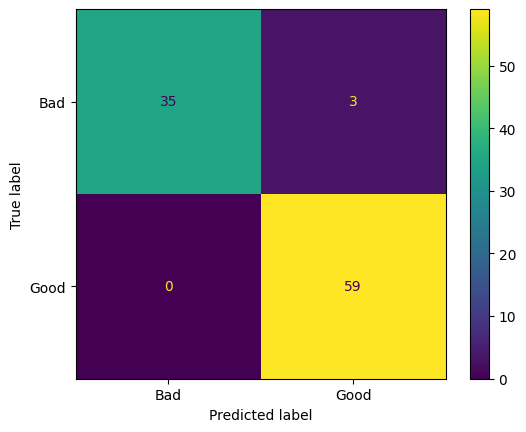

In [11]:
true_y = np.array(y_test);

confusion_matrix1 = confusion_matrix(true_y, tensor_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix1, display_labels = ["Bad", "Good"])

cm_display.plot()
plt.show()

## Confusion Matrix and Accuracy for Real Images

In this section, we create a confusion matrix to evaluate the model's performance on real images.


2/2 [==============================] - 0s 3ms/step


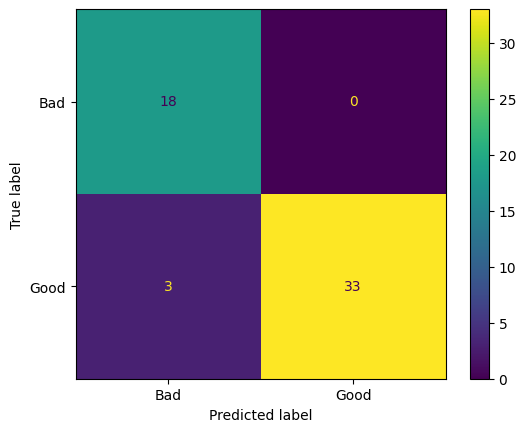

Accuracy on real Images 0.9444444444444444


In [12]:
pred3 = model.predict(X_test_real)
test_pred_real = []
for p in pred3:
    if (p[0] > 0.4):
        test_pred_real.append(1)
    else:
        test_pred_real.append(0)

true_y3 = np.array(y_test_real);

confusion_matrix_real = confusion_matrix(true_y3, test_pred_real)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_real, display_labels = ["Bad", "Good"])

cm_display.plot()
plt.show()

print(f'Accuracy on real Images {accuracy_score(y_test_real, test_pred_real)}')

# Saving the Trained Model

In [13]:
model.save('../models/NN_tree.tensorflow')

INFO:tensorflow:Assets written to: ../models/NN_tree.tensorflow/assets


INFO:tensorflow:Assets written to: ../models/NN_tree.tensorflow/assets


# Convert and Save TensorFlow Lite Model

In this section, we convert the trained pose classification model to TensorFlow Lite format for efficient deployment on various platforms. 

- The model is optimized for resource-constrained devices using `tf.lite.Optimize.DEFAULT`.
- It is saved as "NN_tree_testing.tflite" for deployment in edge devices and mobile applications.

This conversion enables versatile and efficient model deployment.


In [14]:
converter = tf.lite.TFLiteConverter.from_saved_model('../models/NN_tree.tensorflow') # path to the SavedModel directory
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the model.
with open('../models/NN_tree.tflite', 'wb') as f:
  f.write(tflite_model)

2023-11-04 14:41:57.430959: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-11-04 14:41:57.430974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-11-04 14:41:57.431824: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ../models/NN_tree.tensorflow
2023-11-04 14:41:57.433568: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-11-04 14:41:57.433575: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: ../models/NN_tree.tensorflow
2023-11-04 14:41:57.437357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-11-04 14:41:57.438422: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-11-04 14:41:57.469602: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: 

# TensorFlow Lite Model Evaluation

In this section, we evaluate the TensorFlow Lite model and measure its accuracy on test data


In [15]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  predicted_label = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    
    if (output()[0] > 0.4):
        predicted_label.append(1) #good pose
    else:
        predicted_label.append(0)
    

  # Compare prediction results with ground truth labels to calculate accuracy.
  #y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, predicted_label)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_path='../models/NN_tree.tflite')
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.9278350515463918
